In [2]:
import numpy as np
from scipy import sparse
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ipywidgets import interact, interactive
import ipywidgets as widgets
import time

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family'] = ['WenQuanYi Zen Hei']
plt.rcParams['font.serif'] = ['WenQuanYi Zen Hei']
# matplotlib.rcParams['font.serif'] = ['WenQuanYi Zen Hei']

In [30]:
class jack():
    def __init__(self,lam1=3,lam2=4,sig1=3,sig2=2,max_num=20,car_earning=10,discount=0.9,move_cost=2):
        # 租出去 lam
        # 收回 sig
        self.lam1=lam1
        self.lam2=lam2
        self.sig1=sig1
        self.sig2=sig2
        self.max_num=max_num
        self.car_earning=car_earning
        self.discount=discount
        self.move_cost=move_cost
        
        prob_b1=np.array([stats.poisson.pmf(k,lam1) for k in range(max_num+1)])
        prob_b1_cum=1-np.cumsum(prob_b1)
        Ru=np.arange(max_num+1)*prob_b1_cum
        Rg=np.cumsum(np.arange(max_num+1)*prob_b1)
        self.prob_b1=prob_b1
        self.prob_b1_cum=prob_b1_cum
        self.R_b1=car_earning*(Ru+Rg)

        prob_b2=np.array([stats.poisson.pmf(k,lam2) for k in range(max_num+1)])
        prob_b2_cum=1-np.cumsum(prob_b2)
        Ru=np.arange(max_num+1)*prob_b2_cum
        Rg=np.cumsum(np.arange(max_num+1)*prob_b2)
        self.prob_b2=prob_b2
        self.prob_b2_cum=prob_b2_cum
        self.R_b2=car_earning*(Ru+Rg)

        #### ----------------- ####
        ## Ps1[i,j]车库1从库存i到库存j的概率
        ## P(s[0]=i,s'[0]=i+k)=P(s[0]=i-1,s'[0]=i+k-1)+P_lam1(i)*P_sig1(i+k)
        Ps1=np.zeros((max_num+1,max_num+1)) ## s=(i,),s'=(j,),Pss[i,j]=P(s[0]->s'[0])
        Ps2=np.zeros((max_num+1,max_num+1))

        prob_r1=np.array([stats.poisson.pmf(k,sig1) for k in range(max_num+1)])
        prob_r2=np.array([stats.poisson.pmf(k,sig2) for k in range(max_num+1)])

        prob_r1_cum=1-np.cumsum(prob_r1)
        prob_r2_cum=1-np.cumsum(prob_r2)
        inverse_prob_b1_cum=prob_b1_cum[::-1]
        inverse_prob_b2_cum=prob_b2_cum[::-1]
        inverse_prob_r1_cum=prob_r1_cum[::-1]
        inverse_prob_r2_cum=prob_r2_cum[::-1]

        ## ver2
        Ps1[:,0]=prob_b1*prob_r1[0]
        Ps1[-1,0]=0# Ps1[0-1,1-1]用到了，要是0，后面再赋值
        for s in range(0,Ps1.shape[0]):
            for k in range(1,Ps1.shape[1]):
                Ps1[s,k]=Ps1[s-1,k-1]+prob_b1[s]*prob_r1[k] # 还缺 借车>s,还车=k
            Ps1[s,-1]=Ps1[s,-1]+prob_b1_cum[s]*prob_r1_cum[k]+prob_b1[:(s+1)]@inverse_prob_r1_cum[s::-1] # 还缺 借车>s,还车>20
        mat1=prob_b1_cum.reshape((-1,1));mat2=prob_r1.reshape((-1,1))
        # mat2[-1]=prob_r1_cum[-1]
        Ps1[-1,0]=prob_b1[-1]*prob_r1[0]
        Ps1=Ps1+mat1@mat2.T

        Ps2[:,0]=prob_b2*prob_r2[0]
        Ps2[-1,0]=0# Ps2[0-1,1-1]用到了，要是0，后面再赋值
        for s in range(0,Ps2.shape[0]):
            for k in range(1,Ps2.shape[1]):
                Ps2[s,k]=Ps2[s-1,k-1]+prob_b2[s]*prob_r2[k] # 还缺 借车>s,还车=k
            Ps2[s,-1]=Ps2[s,-1]+prob_b2_cum[s]*prob_r2_cum[k]+prob_b2[:(s+1)]@inverse_prob_r2_cum[s::-1] # 还缺 借车>s,还车>20
        mat1=prob_b2_cum.reshape((-1,1));mat2=prob_r2.reshape((-1,1))
        # mat2[-1]=prob_r1_cum[-1]
        Ps2[-1,0]=prob_b2[-1]*prob_r2[0]
        Ps2=Ps2+mat1@mat2.T
        self.Ps1=Ps1
        self.Ps2=Ps2

    def policy_iteration(self,threshold=1e-3):
        discount=self.discount
        max_num=self.max_num
        v=np.zeros((max_num+1,max_num+1)) # 车库1×车库2
        v_snew=np.zeros((max_num+1,max_num+1))
        v_old=np.zeros((max_num+1,max_num+1))
        policy=np.zeros((max_num+1,max_num+1),dtype=np.int32) # s=(),a=pi(s)

        policy_stable=False
        iter_num=0

        _, axes = plt.subplots(2, 3, figsize=(40, 20))
        # 调整子图的间距，wspace=0.1为水平间距，hspace=0.2为垂直间距
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        # 这里将子图形成一个1*6的列表
        axes = axes.flatten()
        car_range=np.arange(0,max_num+1)
        
        # 策略改进中所有状态(c1,c2) equal range(21),range(21)的迪卡尔集
        # s_new_all=[]
        # for a in range(-5,6):
        #     s1_min=np.max((0,a))
        #     s1_max=np.min((max_num,max_num+a))
        #     s2_min=np.max((0,-a))
        #     s2_max=np.min((max_num,max_num-a))
        #     s_new_all+=[(s1,s2) for s1 in range(s1_min,s1_max+1) for s2 in range(s2_min,s2_max+1)]
        # s_new_all=set(s_new_all)
        start=time.time()
        while not policy_stable:
            print(f"iter_num: {iter_num}")
            ## 第二天早上状态
            s1_new=car_range.reshape((-1,1))-policy
            s2_new=car_range.reshape((1,-1))+policy
            
            # 当天收益，将只与第二天早上状态有关的收益先求出
            r_now=-self.move_cost*np.abs(policy)+self.R_b1[s1_new]+self.R_b2[s2_new]
            
            ## 避免重复计算
            s_new=list(zip(s1_new.reshape((-1,)),s2_new.reshape((-1,))))
            s_new_unique=set(s_new)
            value_iter_num=0
            while True:
                ## 策略评估
                ## 计算 v_snew=\sum P(s'|s,a)V(s')
                value_iter_num+=1
                for s in s_new_unique:
                    s1=s[0]
                    s2=s[1]
                    p_snew=self.Ps1[s1,:].reshape((-1,1))@self.Ps2[s2,:].reshape((1,-1))
                    v_snew[s1,s2]=discount*np.sum(p_snew*v)
                v_old=v.copy()
                ## 根据action和s(c1,c2)得到第二天早上的状态s_new,收益就只和s_new有关了，s和a都不用考虑
                v=v_snew[s1_new,s2_new]+r_now
                detal=np.max(np.abs(v-v_old))
                if detal<threshold:break
            print(f"策略评估完成,迭代{value_iter_num}次")
            
            # 求所有状态的价值（不包含移车费）
            # for s1_new in range(max_num+1):
            #     for s2_new in range(max_num+1):
            #         p_snew=self.Ps1[s1_new,:].reshape((-1,1))@self.Ps2[s2_new,:].reshape((1,-1))
            #         v_snew[s1_new,s2_new]=discount*np.sum(p_snew*v)
            # 耗时是原来计算方式的3/4
            for s1_new in range(max_num+1):
                tmp=np.sum(v*self.Ps1[s1_new,:].reshape((-1,1)),axis=0).reshape((-1,1))
                v_tmp=self.Ps2@tmp
                v_snew[s1_new,:]=v_tmp.reshape((-1,))
            v_snew=discount*v_snew+self.R_b1.reshape((-1,1))+self.R_b2.reshape((1,-1))

            # v_base=v.copy()
            # for a in range(-5,6):
            #     s1_min=max(0,a)
            #     s1_max=min(max_num,max_num+a)
            #     s2_min=max(0,-a)
            #     s1_max=min(max_num,max_num-a)
            #     ## 可执行动作a的状态
            #     idx=np.ix_(np.arange(s1_min,s1_max+1),np.arange(s2_min,s2_max+1))
            #     ## 可执行动作a状态的v
            #     v_a=-self.move_cost*np.abs(a)+v_snew[idx]
            #     idx_update=(v_base[idx]+1e-6<v_a)
            #     policy[idx][idx_update]=a
            #     v_base[idx][idx_update]=v_a
            
            policy_stable=True
            for car1 in range(21):
                for car2 in range(21):
                    v_base=v[car1,car2]
                    a_lower=-np.min((5,car2,max_num-car1))
                    a_upper=np.min((5,car1,max_num-car2))
                    for a in range(a_lower,a_upper+1):
                        s1=car1-a
                        s2=car2+a
                        val=v_snew[s1,s2]-self.move_cost*np.abs(a)
                        if val>v_base+threshold*10:
                            policy[car1,car2]=a
                            v_base=val
                            policy_stable=False
            if iter_num<5:
                fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iter_num])
                # 定义标签与标题
                fig.set_ylabel('# cars at first location', fontsize=30)
                fig.set_yticks(list(reversed(range(max_num + 1))))
                fig.set_xlabel('# cars at second location', fontsize=30)
                fig.set_title('$\pi{}$'.format(iter_num), fontsize=30)

            iter_num+=1
        end=time.time()
        print(f"耗时：{end-start}")
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-1])
        # 定义标签与标题
        fig.set_ylabel('# cars at first location', fontsize=2)
        fig.set_yticks(list(reversed(range(max_num + 1))))
        fig.set_xlabel('# cars at second location', fontsize=2)
        fig.set_title('$\pi^*$', fontsize=2)
        return policy,v
    
    
    def value_iteration(self,threshold=1e-3):
        discount=self.discount
        max_num=self.max_num
        v=np.zeros((max_num+1,max_num+1)) # 车库1×车库2
        v_snew=np.zeros((max_num+1,max_num+1))
        v_old=np.zeros((max_num+1,max_num+1))
        policy=np.zeros((max_num+1,max_num+1),dtype=np.int32) # s=(),a=pi(s)

        policy_stable=False
        iter_num=0
        start=time.time()
        while iter_num<100:
            # 求第二天所有状态的价值（不包含移车费）
            # for s1_new in range(max_num+1):
            #     for s2_new in range(max_num+1):
            #         p_snew=self.Ps1[s1_new,:].reshape((-1,1))@self.Ps2[s2_new,:].reshape((1,-1))
            #         v_snew[s1_new,s2_new]=np.sum(p_snew*v)
            for s1_new in range(max_num+1):
                tmp=np.sum(v*self.Ps1[s1_new,:].reshape((-1,1)),axis=0).reshape((-1,1))
                v_tmp=self.Ps2@tmp
                v_snew[s1_new,:]=v_tmp.reshape((-1,))
            v_snew=discount*v_snew+self.R_b1.reshape((-1,1))+self.R_b2.reshape((1,-1))
            
            v_old=v.copy()
            for car1 in range(max_num+1):
                for car2 in range(max_num+1):
                    a_lower=-np.min((5,car2,max_num-car1))
                    a_upper=np.min((5,car1,max_num-car2))
                    actions=np.arange(a_lower,a_upper+1)
                    idx1=car1-actions
                    idx2=car2+actions
                    v_new=v_snew[idx1,idx2]-self.move_cost*np.abs(actions)
                    v[car1,car2]=v_new.max()
            if np.max(np.abs(v-v_old))<threshold:
                break
            
            iter_num+=1
        for car1 in range(max_num+1):
            for car2 in range(max_num+1):
                a_lower=-np.min((5,car2,max_num-car1))
                a_upper=np.min((5,car1,max_num-car2))
                actions=np.arange(a_lower,a_upper+1)
                idx1=car1-actions
                idx2=car2+actions
                v_new=v_snew[idx1,idx2]-self.move_cost*np.abs(actions)
                policy[car1,car2]=actions[v_new.argmax()]
                    
        end=time.time()
        print(f"耗时：{end-start}")
        print(f"iter_num: {iter_num}")
        fig=plt.figure()
        ax=fig.add_subplot()
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=ax)
        # 定义标签与标题
        fig.set_ylabel('# cars at first location', fontsize=2)
        fig.set_yticks(list(reversed(range(max_num + 1))))
        fig.set_xlabel('# cars at second location', fontsize=2)
        fig.set_title('$\pi^*$', fontsize=2)
        return policy,v

In [31]:
obj=jack()

iter_num: 0
策略评估完成,迭代104次
iter_num: 1
策略评估完成,迭代70次
iter_num: 2
策略评估完成,迭代58次
iter_num: 3
策略评估完成,迭代21次
iter_num: 4
策略评估完成,迭代6次
耗时：2.51961350440979


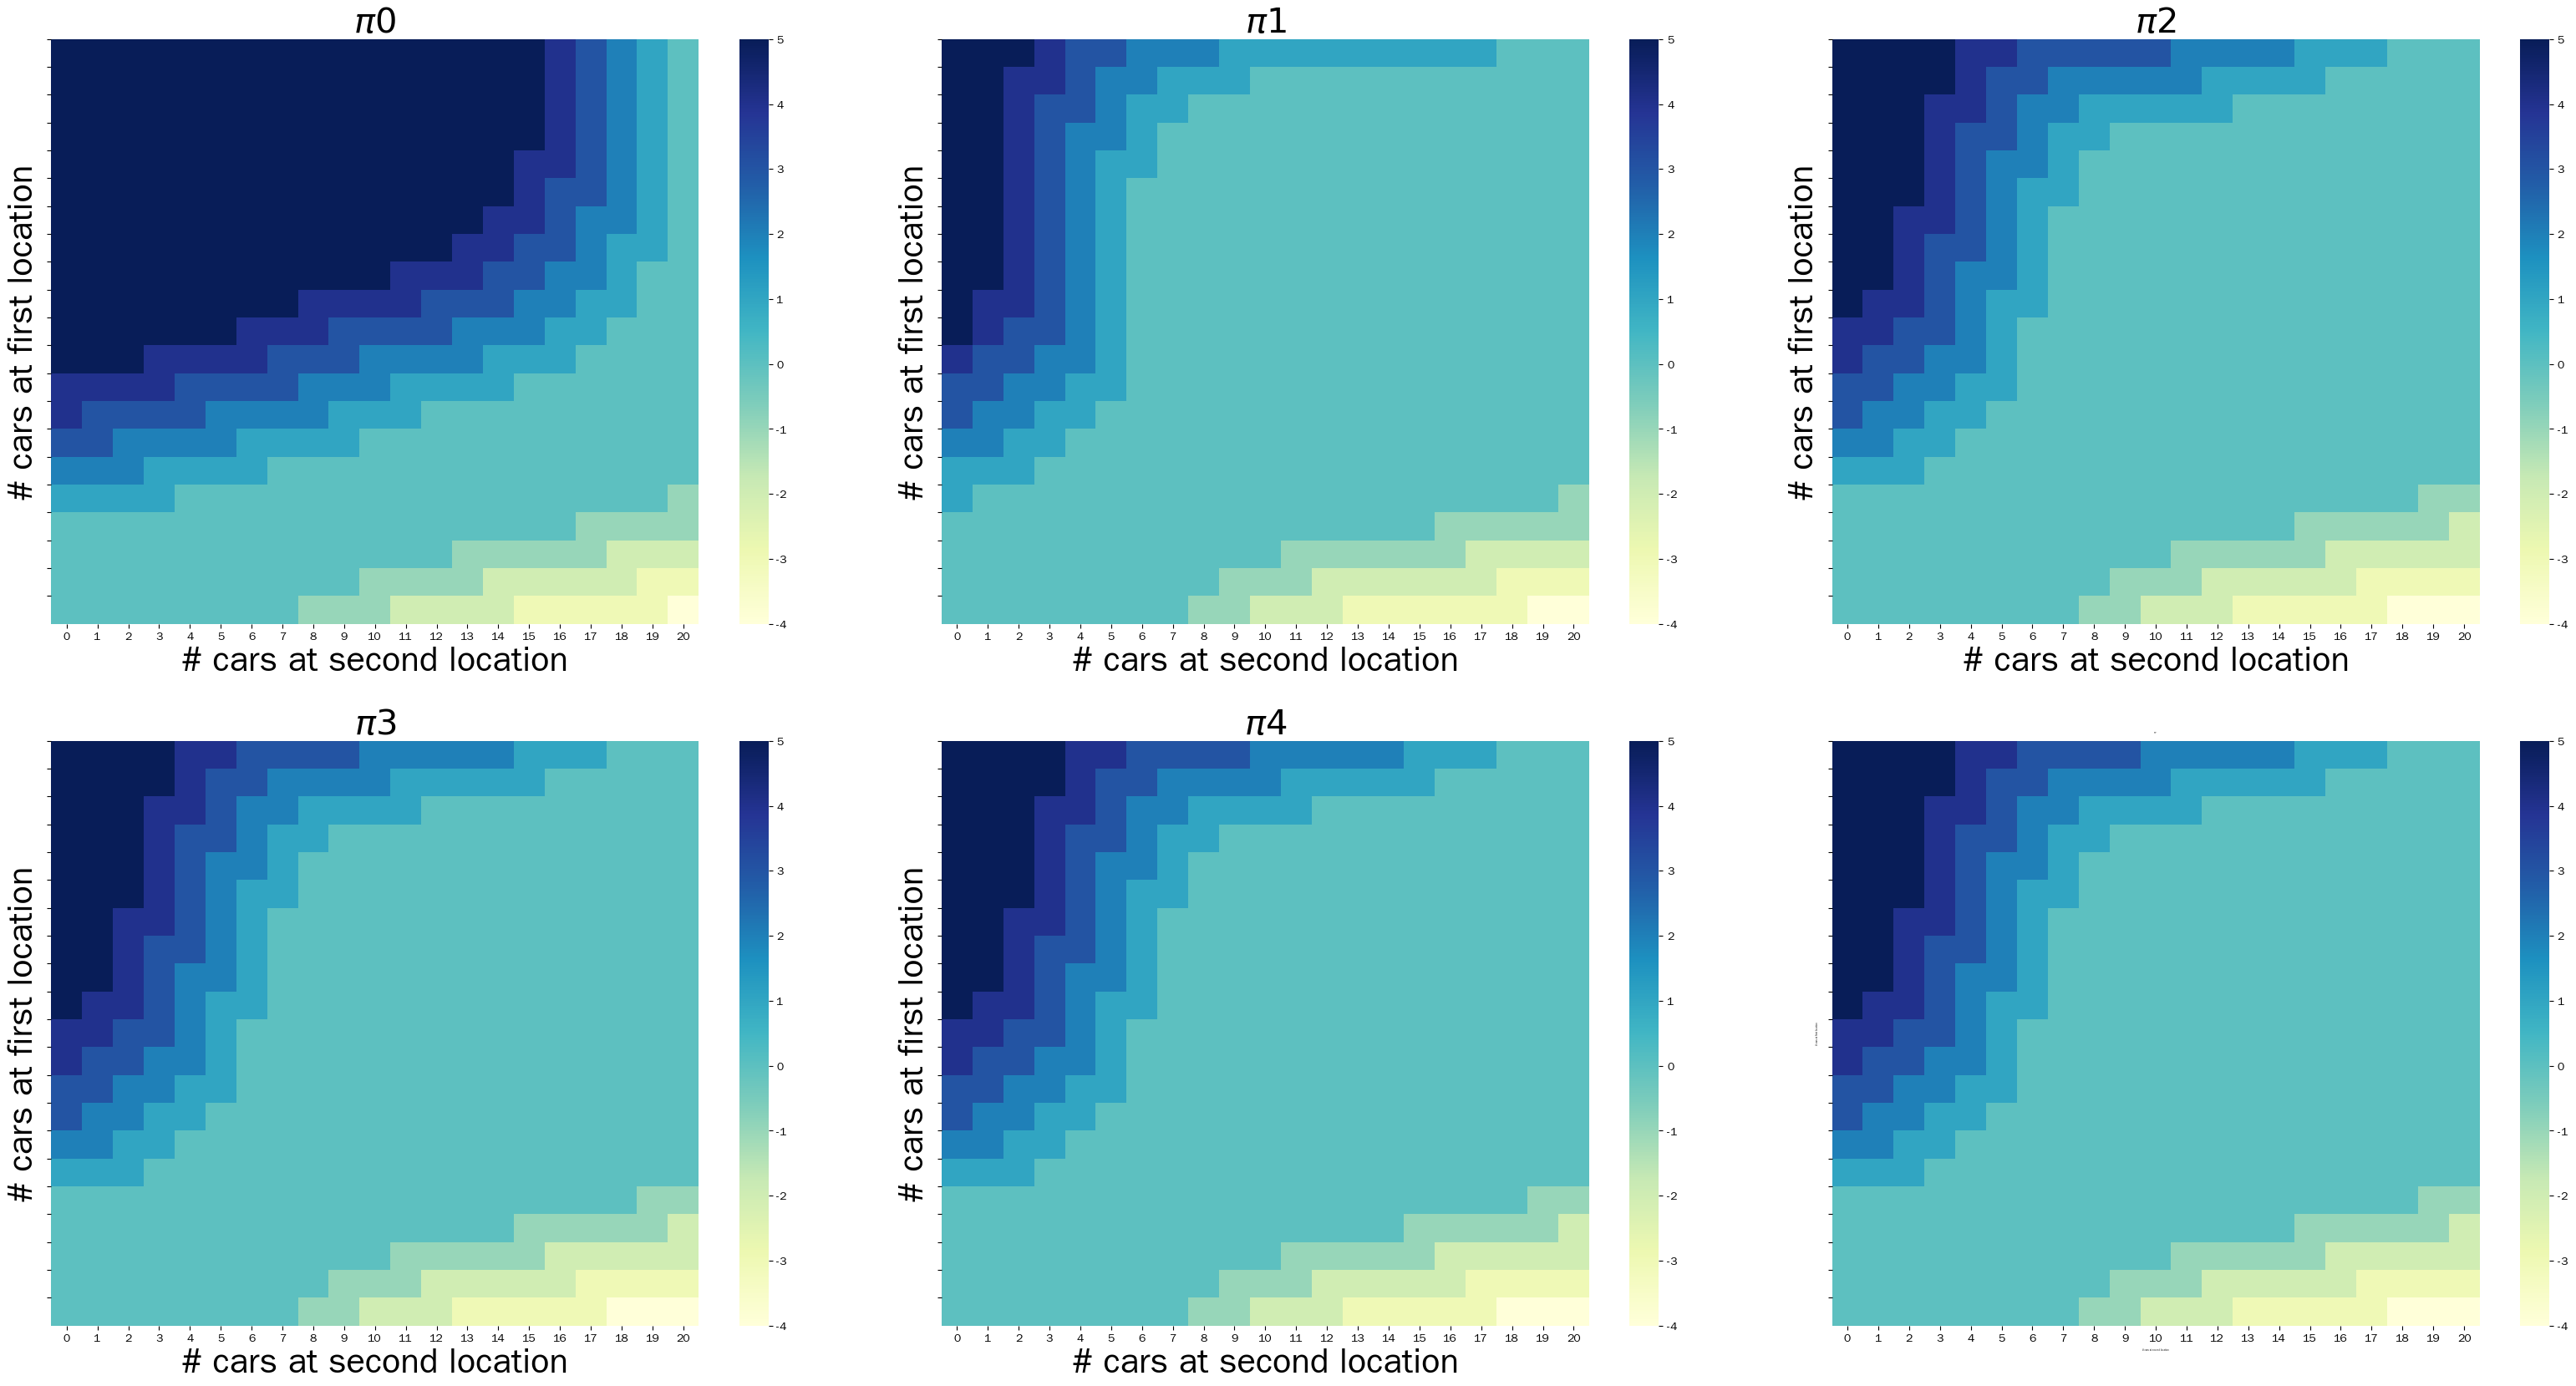

In [32]:
policy,v=obj.policy_iteration()

耗时：1.0853314399719238
iter_num: 81


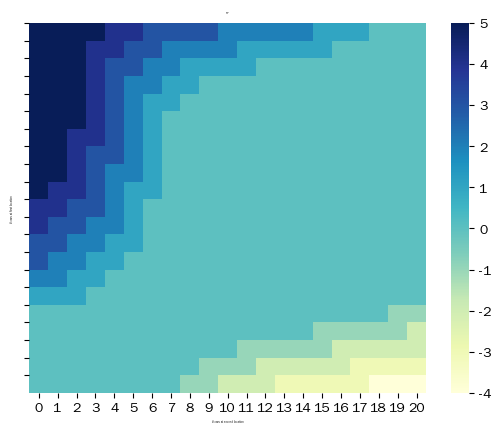

In [36]:
policy,v=obj.value_iteration(1e-2)

In [13]:
class jack_modify():
    def __init__(self,lam1=3,lam2=4,sig1=3,sig2=2,max_num=20,car_earning=10,discount=0.9,move_cost=2,paking_cost=4):
        # 租出去 lam
        # 收回 sig
        self.lam1=lam1
        self.lam2=lam2
        self.sig1=sig1
        self.sig2=sig2
        self.max_num=max_num
        self.car_earning=car_earning
        self.discount=discount
        self.move_cost=move_cost
        self.paking_cost=paking_cost
        
        prob_b1=np.array([stats.poisson.pmf(k,lam1) for k in range(max_num+1)])
        prob_b1_cum=1-np.cumsum(prob_b1)
        Ru=np.arange(max_num+1)*prob_b1_cum
        Rg=np.cumsum(np.arange(max_num+1)*prob_b1)
        self.prob_b1=prob_b1
        self.prob_b1_cum=prob_b1_cum
        self.R_b1=car_earning*(Ru+Rg)

        prob_b2=np.array([stats.poisson.pmf(k,lam2) for k in range(max_num+1)])
        prob_b2_cum=1-np.cumsum(prob_b2)
        Ru=np.arange(max_num+1)*prob_b2_cum
        Rg=np.cumsum(np.arange(max_num+1)*prob_b2)
        self.prob_b2=prob_b2
        self.prob_b2_cum=prob_b2_cum
        self.R_b2=car_earning*(Ru+Rg)

        #### ----------------- ####
        ## Ps1[i,j]车库1从库存i到库存j的概率
        ## P(s[0]=i,s'[0]=i+k)=P(s[0]=i-1,s'[0]=i+k-1)+P_lam1(i)*P_sig1(i+k)
        Ps1=np.zeros((max_num+1,max_num+1)) ## s=(i,),s'=(j,),Pss[i,j]=P(s[0]->s'[0])
        Ps2=np.zeros((max_num+1,max_num+1))

        prob_r1=np.array([stats.poisson.pmf(k,sig1) for k in range(max_num+1)])
        prob_r2=np.array([stats.poisson.pmf(k,sig2) for k in range(max_num+1)])

        prob_r1_cum=1-np.cumsum(prob_r1)
        prob_r2_cum=1-np.cumsum(prob_r2)
        inverse_prob_b1_cum=prob_b1_cum[::-1]
        inverse_prob_b2_cum=prob_b2_cum[::-1]
        inverse_prob_r1_cum=prob_r1_cum[::-1]
        inverse_prob_r2_cum=prob_r2_cum[::-1]

        ## ver2
        Ps1[:,0]=prob_b1*prob_r1[0]
        Ps1[-1,0]=0# Ps1[0-1,1-1]用到了，要是0，后面再赋值
        for s in range(0,Ps1.shape[0]):
            for k in range(1,Ps1.shape[1]):
                Ps1[s,k]=Ps1[s-1,k-1]+prob_b1[s]*prob_r1[k] # 还缺 借车>s,还车=k
            Ps1[s,-1]=Ps1[s,-1]+prob_b1_cum[s]*prob_r1_cum[k]+prob_b1[:(s+1)]@inverse_prob_r1_cum[s::-1] # 还缺 借车>s,还车>20
        mat1=prob_b1_cum.reshape((-1,1));mat2=prob_r1.reshape((-1,1))
        # mat2[-1]=prob_r1_cum[-1]
        Ps1[-1,0]=prob_b1[-1]*prob_r1[0]
        Ps1=Ps1+mat1@mat2.T

        Ps2[:,0]=prob_b2*prob_r2[0]
        Ps2[-1,0]=0# Ps2[0-1,1-1]用到了，要是0，后面再赋值
        for s in range(0,Ps2.shape[0]):
            for k in range(1,Ps2.shape[1]):
                Ps2[s,k]=Ps2[s-1,k-1]+prob_b2[s]*prob_r2[k] # 还缺 借车>s,还车=k
            Ps2[s,-1]=Ps2[s,-1]+prob_b2_cum[s]*prob_r2_cum[k]+prob_b2[:(s+1)]@inverse_prob_r2_cum[s::-1] # 还缺 借车>s,还车>20
        mat1=prob_b2_cum.reshape((-1,1));mat2=prob_r2.reshape((-1,1))
        # mat2[-1]=prob_r1_cum[-1]
        Ps2[-1,0]=prob_b2[-1]*prob_r2[0]
        Ps2=Ps2+mat1@mat2.T
        self.Ps1=Ps1
        self.Ps2=Ps2

    def policy_iteration(self,threshold=1e-3):
        discount=self.discount
        max_num=self.max_num
        v=np.zeros((max_num+1,max_num+1)) # 车库1×车库2
        v_snew=np.zeros((max_num+1,max_num+1))
        v_old=np.zeros((max_num+1,max_num+1))
        policy=np.zeros((max_num+1,max_num+1),dtype=np.int32) # s=(),a=pi(s)

        policy_stable=False
        iter_num=0

        _, axes = plt.subplots(2, 3, figsize=(40, 20))
        # 调整子图的间距，wspace=0.1为水平间距，hspace=0.2为垂直间距
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        # 这里将子图形成一个1*6的列表
        axes = axes.flatten()
        car_range=np.arange(0,max_num+1)
        
        start=time.time()
        while (not policy_stable) and iter_num<100:
            print(f"iter_num: {iter_num}")
            ## 第二天早上状态
            s1_new=car_range.reshape((-1,1))-policy
            s2_new=car_range.reshape((1,-1))+policy
            
            # 当天收益，将只与第二天早上状态有关的收益先求出
            paking_fee=self.paking_cost*(s1_new>10)+self.paking_cost*(s2_new>10)
            r_now=-paking_fee-self.move_cost*np.abs(policy)+self.R_b1[s1_new]+self.R_b2[s2_new]
            r_now[policy>0]+=self.move_cost

            ## 避免重复计算
            s_new=list(zip(s1_new.reshape((-1,)),s2_new.reshape((-1,))))
            s_new_unique=set(s_new)
            value_iter_num=0
            while True:
                ## 策略评估
                ## 计算 v_snew=\sum P(s'|s,a)V(s')
                value_iter_num+=1
                for s in s_new_unique:
                    s1=s[0]
                    s2=s[1]
                    p_snew=self.Ps1[s1,:].reshape((-1,1))@self.Ps2[s2,:].reshape((1,-1))
                    v_snew[s1,s2]=discount*np.sum(p_snew*v)
                v_old=v.copy()
                ## 根据action和s(c1,c2)得到第二天早上的状态s_new,收益就只和s_new有关了，s和a都不用考虑
                v=v_snew[s1_new,s2_new]+r_now
                detal=np.max(np.abs(v-v_old))
                if detal<threshold:break
            print(f"策略评估完成,迭代{value_iter_num}次")
            
            # 求所有状态的价值（不包含移车费）
            for s1_new in range(max_num+1):
                for s2_new in range(max_num+1):
                    p_snew=self.Ps1[s1_new,:].reshape((-1,1))@self.Ps2[s2_new,:].reshape((1,-1))
                    v_snew[s1_new,s2_new]=discount*np.sum(p_snew*v)
            v_snew=v_snew+self.R_b1.reshape((-1,1))+self.R_b2.reshape((1,-1))
            v_snew[11:,:]+=self.paking_cost
            v_snew[:,11:]+=self.paking_cost
            
            policy_stable=True
            improve_count=0
            for car1 in range(21):
                for car2 in range(21):
                    v_base=v[car1,car2]
                    a_lower=-np.min((5,car2,max_num-car1))
                    a_upper=np.min((5,car1,max_num-car2))
                    modify=0
                    for a in range(a_lower,a_upper+1):
                        s1=car1-a
                        s2=car2+a
                        a_charge=a-1 if a>0 else a
                        val=v_snew[s1,s2]-self.move_cost*np.abs(a_charge)
                        if val>v_base+threshold*10:
                            policy[car1,car2]=a
                            v_base=val
                            policy_stable=False
                            modify=1
                    improve_count+=modify

            print(f"策略提升完成，修改{improve_count}次")
            if iter_num<5:
                fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iter_num])
                # 定义标签与标题
                fig.set_ylabel('# cars at first location', fontsize=30)
                fig.set_yticks(list(reversed(range(max_num + 1))))
                fig.set_xlabel('# cars at second location', fontsize=30)
                fig.set_title('$\pi{}$'.format(iter_num), fontsize=30)

            iter_num+=1
        end=time.time()
        print(f"耗时：{end-start}")
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-1])
        # 定义标签与标题
        fig.set_ylabel('# cars at first location', fontsize=2)
        fig.set_yticks(list(reversed(range(max_num + 1))))
        fig.set_xlabel('# cars at second location', fontsize=2)
        fig.set_title('$\pi^*$', fontsize=2)
        return policy,v
    
    
    def value_iteration(self,threshold=1e-3):
        discount=self.discount
        max_num=self.max_num
        v=np.zeros((max_num+1,max_num+1)) # 车库1×车库2
        v_snew=np.zeros((max_num+1,max_num+1))
        v_old=np.zeros((max_num+1,max_num+1))
        policy=np.zeros((max_num+1,max_num+1),dtype=np.int32) # s=(),a=pi(s)

        policy_stable=False
        iter_num=0
        start=time.time()
        while iter_num<100:
            # 求第二天所有状态的价值（不包含移车费）
            for s1_new in range(max_num+1):
                for s2_new in range(max_num+1):
                    p_snew=self.Ps1[s1_new,:].reshape((-1,1))@self.Ps2[s2_new,:].reshape((1,-1))
                    v_snew[s1_new,s2_new]=discount*np.sum(p_snew*v)
            v_snew=v_snew+self.R_b1.reshape((-1,1))+self.R_b2.reshape((1,-1))
            v_snew[11:,:]+=self.paking_cost
            v_snew[:,11:]+=self.paking_cost
            
            v_old=v.copy()
            for car1 in range(max_num+1):
                for car2 in range(max_num+1):
                    a_lower=-np.min((5,car2,max_num-car1))
                    a_upper=np.min((5,car1,max_num-car2))
                    actions=np.arange(a_lower,a_upper+1)
                    idx1=car1-actions
                    idx2=car2+actions
                    v_new=v_snew[idx1,idx2]-self.move_cost*np.abs(actions)
                    v_new[actions>0]+=self.move_cost
                    v[car1,car2]=v_new.max()
            if np.max(np.abs(v-v_old))<threshold:
                break
            
            iter_num+=1
        for car1 in range(max_num+1):
            for car2 in range(max_num+1):
                a_lower=-np.min((5,car2,max_num-car1))
                a_upper=np.min((5,car1,max_num-car2))
                actions=np.arange(a_lower,a_upper+1)
                idx1=car1-actions
                idx2=car2+actions
                v_new=v_snew[idx1,idx2]-self.move_cost*np.abs(actions)
                v_new[actions>0]+=self.move_cost
                policy[car1,car2]=actions[v_new.argmax()]
                    
        end=time.time()
        print(f"耗时：{end-start}")
        print(f"iter_num: {iter_num}")
        fig=plt.figure()
        ax=fig.add_subplot()
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=ax)
        # 定义标签与标题
        fig.set_ylabel('# cars at first location', fontsize=2)
        fig.set_yticks(list(reversed(range(max_num + 1))))
        fig.set_xlabel('# cars at second location', fontsize=2)
        fig.set_title('$\pi^*$', fontsize=2)
        return policy,v

In [14]:
obj=jack_modify()

iter_num: 0
策略评估完成,迭代103次
策略提升完成，修改415次
iter_num: 1
策略评估完成,迭代76次
策略提升完成，修改399次
iter_num: 2
策略评估完成,迭代63次
策略提升完成，修改339次
iter_num: 3
策略评估完成,迭代44次
策略提升完成，修改334次
iter_num: 4
策略评估完成,迭代29次
策略提升完成，修改326次
iter_num: 5
策略评估完成,迭代2次
策略提升完成，修改325次
iter_num: 6
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 7
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 8
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 9
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 10
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 11
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 12
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 13
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 14
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 15
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 16
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 17
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 18
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 19
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 20
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 21
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 22
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 23
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 24
策略评估完成,迭代1次
策略提升完成，修改325次
iter_num: 25
策略评估完成,迭代1次
策略提升

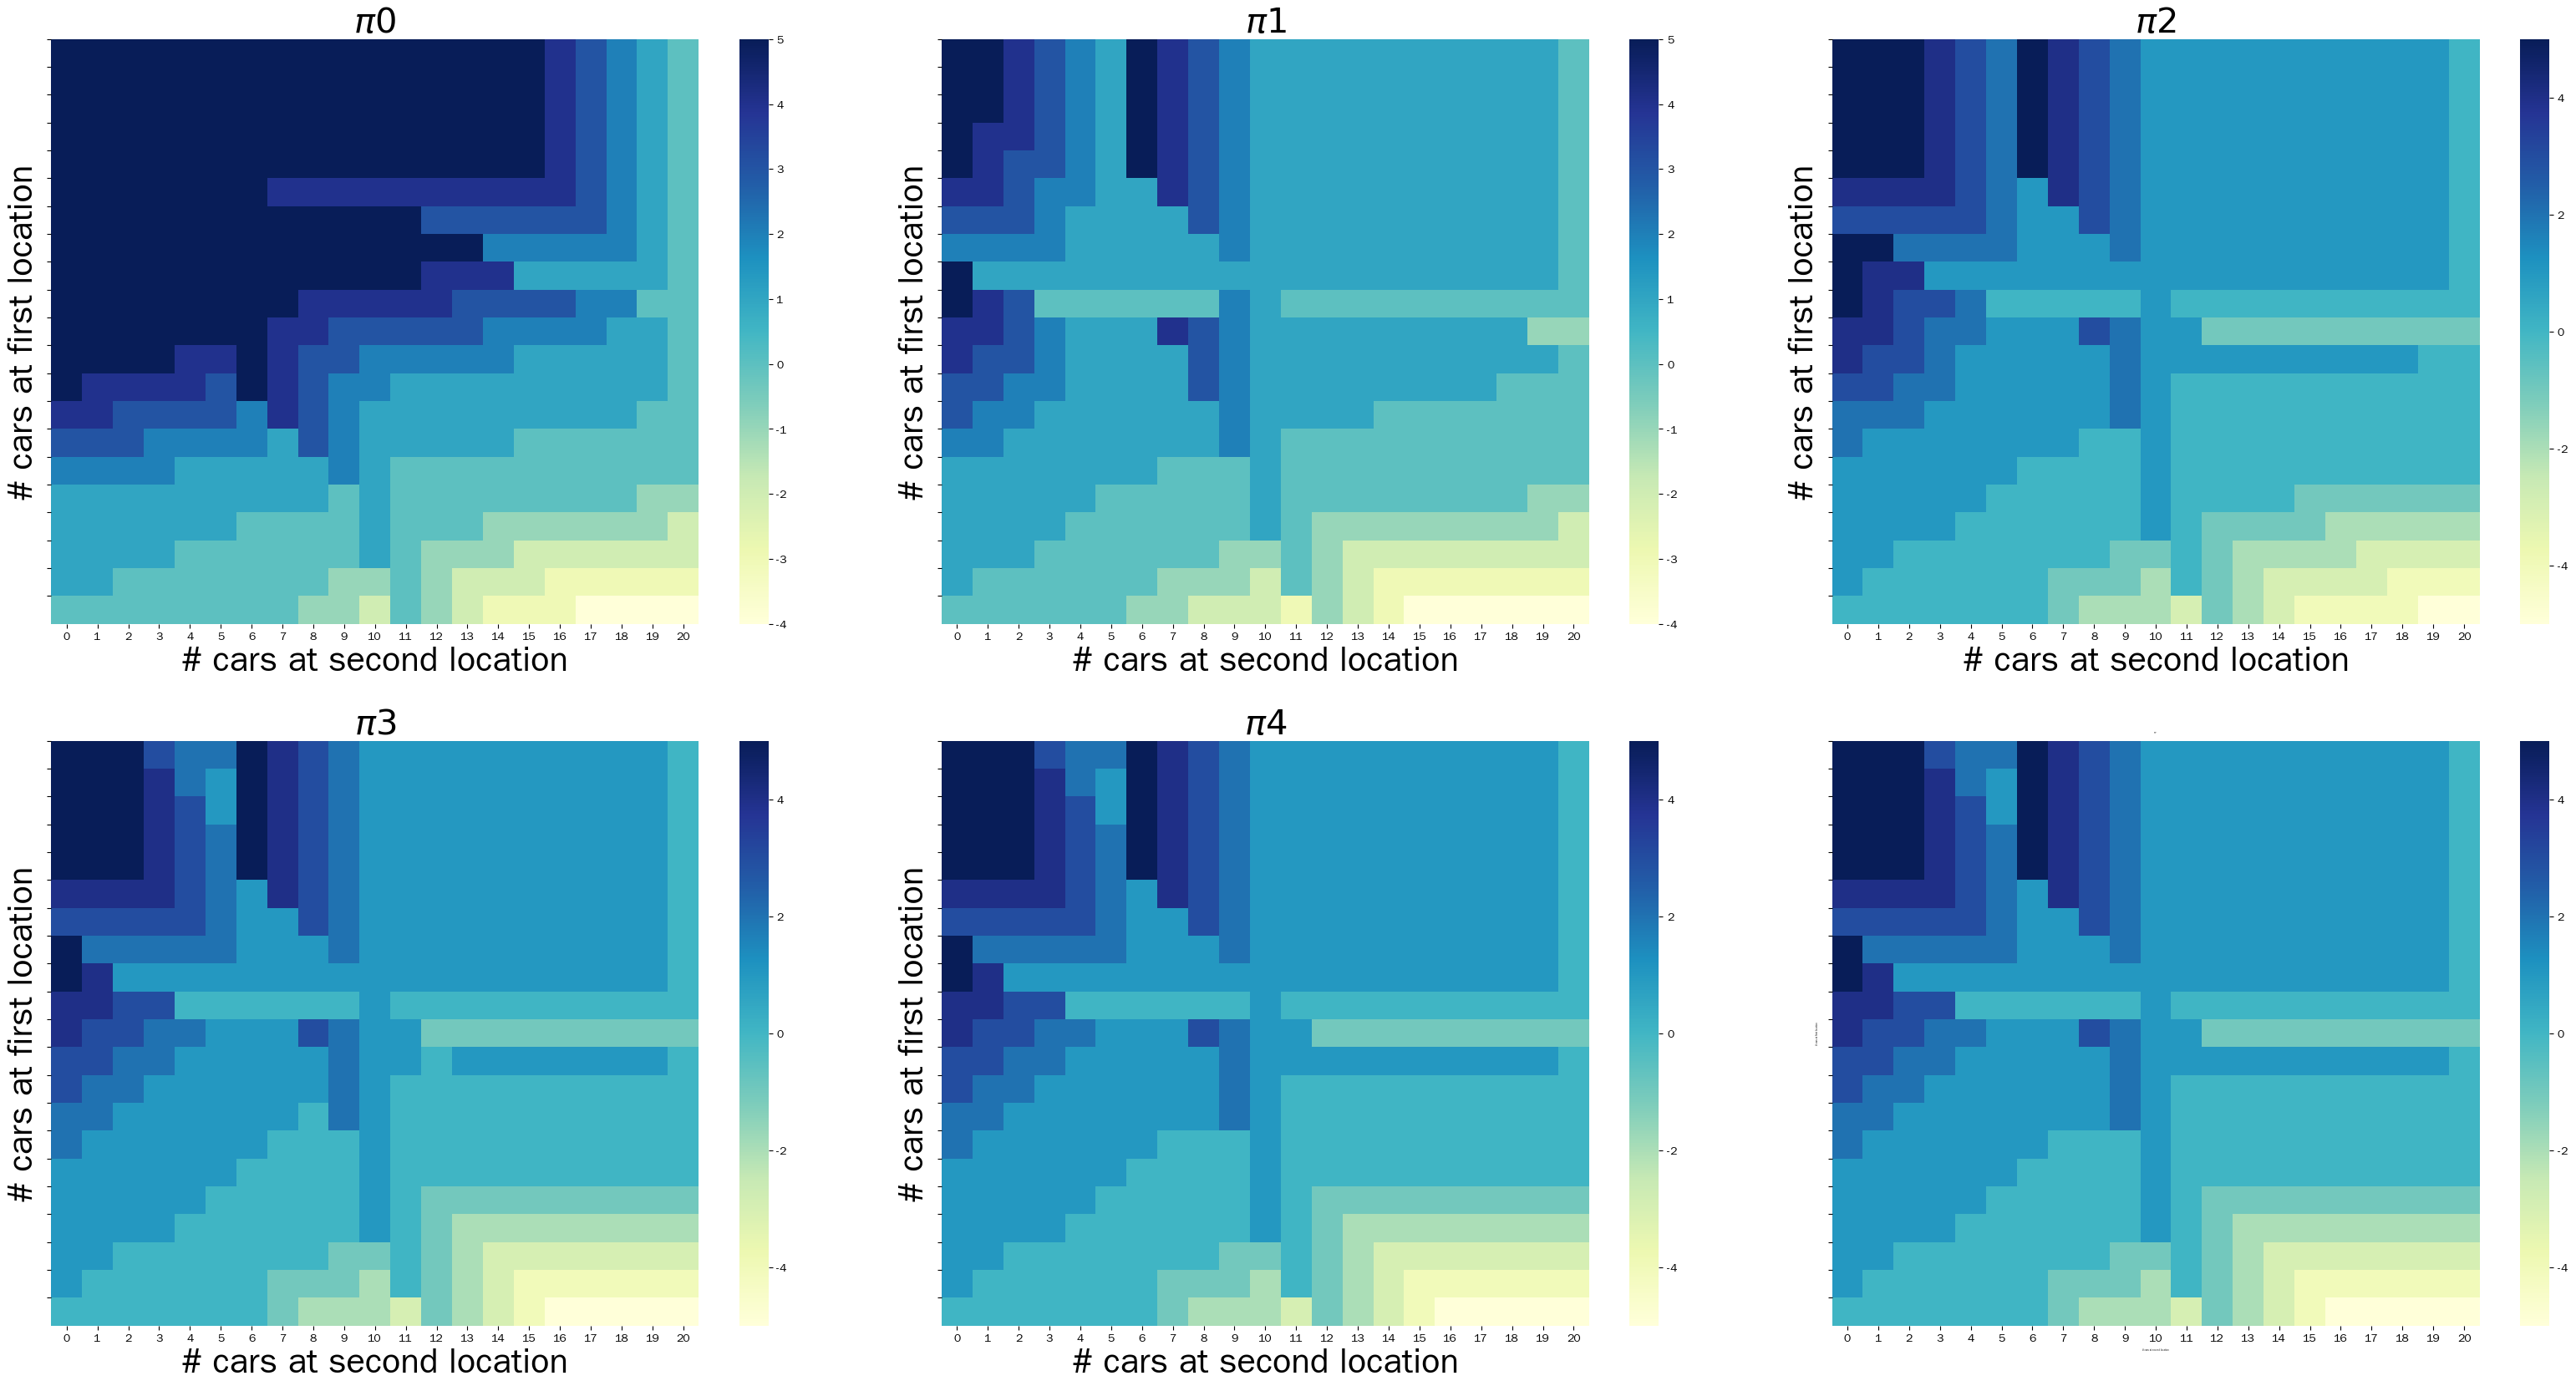

In [15]:
policy,v=obj.policy_iteration()

耗时：2.093285322189331
iter_num: 100


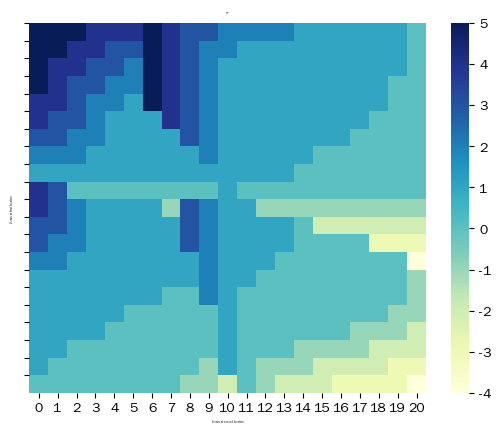

In [18]:
policy,v=obj.value_iteration()